In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import os
import torch
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('dark_background')
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from astropy.io import fits
from copy import deepcopy
import random
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# from scipy.ndimage import gaussian_filter
from os.path import join as oj
import sys
import acd
from tqdm import tqdm
import pickle as pkl
import torchvision
import models
import time
sys.path.append('../../visualization')
sys.path.append('..')
import viz_2d as viz
import util
from functools import partial
from transforms_torch import bandpass_filter
from data import *
from style import *
data_path = '/scratch/users/vision/data/cosmo'
torch.manual_seed(42)
np.random.seed(42)
mnu_dataset = MassMapsDataset(oj(data_path, 'cosmological_parameters.txt'),  oj(data_path, 'z1_256'))

## load model

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

m = models.load_model(model_name='resnet18', device=device)

data_transform = transforms.Compose([ToTensor()])
dataloader = torch.utils.data.DataLoader(MassMapsDataset(oj(data_path, 'cosmological_parameters.txt'),  
                                                         oj(data_path, 'z1_256'),
                                                         transform=data_transform), 
                                         batch_size=64, shuffle=True, num_workers=4)

**check that it makes reasonable preds**

100%|██████████| 100/100 [00:01<00:00, 94.25it/s]


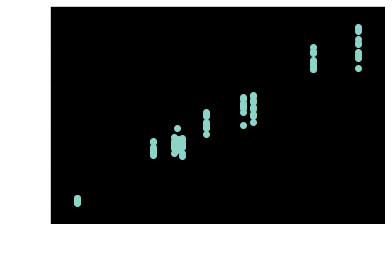

In [3]:
with torch.no_grad():
    result = {'y': [], 'pred': []}
    for i in tqdm(range(100)):
        sample = data_transform(mnu_dataset[i])
        x = sample['image']
        result['y'].append(sample['params'][1].item())
        result['pred'].append(m(x.unsqueeze(0).to(device)).flatten()[1].item())
# print(result)
plt.scatter(result['y'], result['pred'])
plt.xlabel('true param')
plt.ylabel('predicted param')
plt.show()

# calc cd scores

**calc cd scores**

In [4]:
def calc_scores(im_t, model_ft, transform, device='cuda', band_centers=np.linspace(0.1, 0.90, 100)):
    '''Calculate scores across many bands
    '''
    with torch.no_grad():
        x = deepcopy(im_t).to(device)
        model_ft = model_ft.to(device)
        scores = []
        for band_center in band_centers:
            score = acd.cd(x, model_ft, mask=None, model_type='resnet18', 
                           device=device, transform=partial(transform, band_center=band_center, band_width=0.05))
            score = score[0].flatten().detach().cpu().numpy()
            scores.append(score)
    return scores



band_centers = np.linspace(0.1, 0.90, 100)
np.random.seed(42)
scores_list = []
for sample_num in tqdm(range(1, 2)):
    sample = mnu_dataset[sample_num]
    im = np.squeeze(sample['image']).astype(np.float32)
    im_t = torch.Tensor(im).reshape(1, 1, 256, 256)    
    class_num = 1 # output is: [M_nu(eV), Omega_m 10^9*A_s, sigma_8(derived)]
    scores_list.append(calc_scores(im_t, m, bandpass_filter, band_centers=band_centers)) #, class_num=1))
    if sample_num % 100 == 50:
        pkl.dump({'scores_list': np.array(scores_list)}, 
                 open(f'results/scores_list_{i}.pkl', 'wb'))

100%|██████████| 1/1 [00:30<00:00, 30.47s/it]


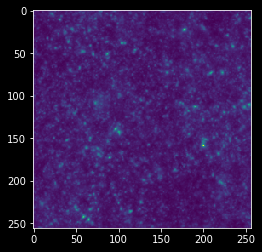

In [17]:
plt.imshow(im)

In [5]:
s = np.array(scores_list)
# plt.plot(scores_list[0, :, 0])

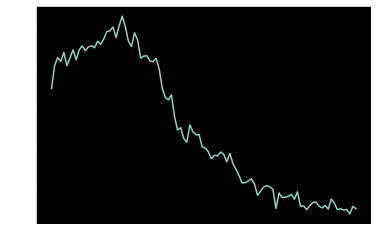

In [6]:
plt.plot(s[0, :, 1])

# viz cd scores

In [ ]:
sigmas = np.linspace(0.1, 0.90, 100)

# plot
scores_list = pkl.load(open('results/scores_list_50.pkl', 'rb'))['scores_list']
scores = np.array(scores_list) # scores is 
s = np.zeros(scores.shape)
for r in range(scores.shape[0]):
    for c in range(scores.shape[1]):
        s[r, c] = scores[r, c][0]
# scores_omega = np.array([s[..., 1] for s in scores])



plt.figure(dpi=150)
plt.plot(sigmas, np.array(s).T, '-', alpha=0.6, color=cb)
plt.plot(sigmas, np.array(s).T.mean(axis=1), '-', color=cr)
plt.xlabel('Frequency band $\pm 0.05$')
# plt.xscale('log')
plt.ylabel('CD Score')
plt.show()    